# Sentiment Analysis using LSTM (Kaggle Dataset)

This notebook builds a **resume-grade sentiment analysis system** using:
- Raw text data (CSV)
- Word-level tokenization
- Padding & masking
- Trainable embeddings
- LSTM (Many-to-One)
- TensorFlow / Keras

The trained model is saved for deployment using Streamlit.


1. IMPORTS & CONFIGURATION

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


In [26]:
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [27]:
# Configuration (LOCKED)
VOCAB_SIZE = 20000
MAX_LEN = 200
EMBED_DIM = 128
LSTM_UNITS = 128
BATCH_SIZE = 32
EPOCHS = 5


UPLOAD & LOAD DATASET

In [28]:
# Load dataset
df = pd.read_csv("/content/sentiment_data.csv")
df.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


DATA INSPECTION & NORMALIZATION

In [29]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  241145 non-null  int64 
 1   Comment     240928 non-null  object
 2   Sentiment   241145 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


In [30]:
df.head(10)


,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2
5,5,we’ve hounding bank adopt apple pay understand...,1
6,6,got apple pay south africa it’s widely accepted,2
7,7,need apple pay physical credit card,1
8,8,united states abundance retailers accept apple...,2
9,9,cambodia universal qr code system scan send mo...,1


Handle column name differences

In [31]:
# Try to infer text and label columns automatically
text_col = None
label_col = None

for col in df.columns:
    if "text" in col.lower() or "review" in col.lower():
        text_col = col
    if "sentiment" in col.lower() or "label" in col.lower():
        label_col = col

print("Text column:", text_col)
print("Label column:", label_col)


Text column: None
Label column: Sentiment


Clean & map labels

In [32]:
text_col = 'Comment'
df = df[[text_col, label_col]].dropna()

In [33]:
df[label_col].value_counts()


,count
Sentiment,
2,103046
1,82777
0,55105


In [34]:
# Normalize labels to binary
df[label_col] = df[label_col].map({
    "positive": 1,
    "negative": 0,
    1: 1,
    0: 0
})


In [35]:
df = df.dropna()


TRAIN / TEST SPLIT

In [36]:
from sklearn.model_selection import train_test_split


In [37]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df[text_col].values,
    df[label_col].values,
    test_size=0.2,
    random_state=42,
    stratify=df[label_col]
)


TOKENIZATION (WORD-LEVEL)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [39]:
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token="<OOV>",
    lower=True
)

tokenizer.fit_on_texts(X_train_text)


In [40]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)


PADDING & MASKING

In [41]:
X_train = pad_sequences(
    X_train_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

X_test = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)


In [42]:
print(X_train.shape, X_test.shape)


(110305, 200) (27577, 200)


LSTM MODEL

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


In [44]:
model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_DIM,
        input_length=MAX_LEN,
        mask_zero=True
    ),
    LSTM(
        LSTM_UNITS,
        dropout=0.2,
        recurrent_dropout=0.2
    ),
    Dense(1, activation="sigmoid")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
model.build(input_shape=(None, MAX_LEN))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

COMPILE & TRAIN

In [46]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [47]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5
2758/2758 ━━━━━━━━━━━━━━━━━━━━ 2111s 763ms/step - accuracy: 0.7868 - loss: 0.4549 - val_accuracy: 0.8831 - val_loss: 0.2891
Epoch 2/5
2758/2758 ━━━━━━━━━━━━━━━━━━━━ 2155s 781ms/step - accuracy: 0.9017 - loss: 0.2470 - val_accuracy: 0.8916 - val_loss: 0.2827
Epoch 3/5
2758/2758 ━━━━━━━━━━━━━━━━━━━━ 2103s 763ms/step - accuracy: 0.9316 - loss: 0.1806 - val_accuracy: 0.8887 - val_loss: 0.3092
Epoch 4/5
2758/2758 ━━━━━━━━━━━━━━━━━━━━ 2084s 756ms/step - accuracy: 0.9527 - loss: 0.1299 - val_accuracy: 0.8825 - val_loss: 0.3600
Epoch 5/5
2758/2758 ━━━━━━━━━━━━━━━━━━━━ 2091s 758ms/step - accuracy: 0.9664 - loss: 0.0925 - val_accuracy: 0.8815 - val_loss: 0.4425


EVALUATION

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


862/862 ━━━━━━━━━━━━━━━━━━━━ 108s 125ms/step - accuracy: 0.8835 - loss: 0.4249
Test Accuracy: 0.8835


TRAINING CURVES

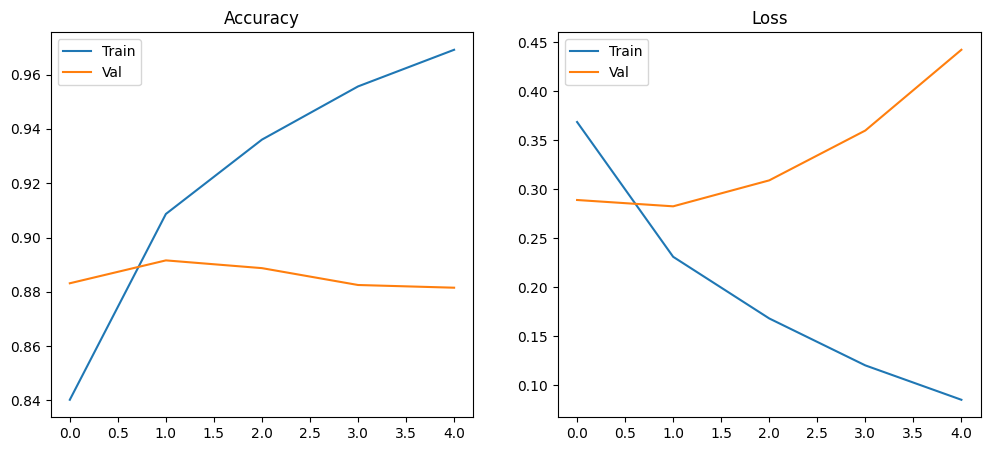

In [49]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


SAVE MODEL & TOKENIZER

In [50]:
model.save("lstm_sentiment.h5")


In [51]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


FINAL SANITY TEST

In [52]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    prob = model.predict(pad)[0][0]
    return prob


In [53]:
predict_sentiment("The movie was absolutely fantastic and emotional")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


np.float32(0.21223657)

In [54]:
predict_sentiment("This was boring, slow, and a complete waste of time")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


np.float32(0.02444737)

In [66]:
# ==============================
# INTERACTIVE SENTIMENT PREDICTOR
# ==============================

import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---- CONFIG ----
MODEL_PATH = "/content/lstm_sentiment.h5"
TOKENIZER_PATH = "/content/tokenizer.pkl"
MAX_LEN = 200

# ---- LOAD MODEL ----
model = tf.keras.models.load_model(MODEL_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

print("✅ Model and tokenizer loaded successfully.")

# ---- PREDICTION FUNCTION ----
def predict_sentiment_label(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(
        seq,
        maxlen=MAX_LEN,
        padding="post",
        truncating="post"
    )
    prob = model.predict(padded, verbose=0)[0][0]
    return "POSITIVE 😊" if prob >= 0.5 else "NEGATIVE 😞"

# ---- INTERACTIVE INPUT ----
review = input("\nEnter a review to analyze sentiment:\n")

if review.strip() == "":
    print("⚠️ Please enter valid text.")
else:
    result = predict_sentiment_label(review)
    print("\n🎯 Sentiment Prediction:", result)


✅ Model and tokenizer loaded successfully.

Enter a review to analyze sentiment:
You're always late.

🎯 Sentiment Prediction: NEGATIVE 😞


In [69]:
# ==============================
# INTERACTIVE SENTIMENT PREDICTOR
# ==============================

import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---- CONFIG ----
MODEL_PATH = "/content/lstm_sentiment.h5"
TOKENIZER_PATH = "/content/tokenizer.pkl"
MAX_LEN = 200

# ---- LOAD MODEL ----
model = tf.keras.models.load_model(MODEL_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

print("✅ Model and tokenizer loaded successfully.")

# ---- PREDICTION FUNCTION ----
def predict_sentiment_label(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(
        seq,
        maxlen=MAX_LEN,
        padding="post",
        truncating="post"
    )
    prob = model.predict(padded, verbose=0)[0][0]
    return "POSITIVE 😊" if prob >= 0.5 else "NEGATIVE 😞"

# ---- INTERACTIVE INPUT ----
review = input("\nEnter a review to analyze sentiment:\n")

if review.strip() == "":
    print("⚠️ Please enter valid text.")
else:
    result = predict_sentiment_label(review)
    print("\n🎯 Sentiment Prediction:", result)


✅ Model and tokenizer loaded successfully.

Enter a review to analyze sentiment:
Great job!", "Well done!", Keep up the fantastic work!

🎯 Sentiment Prediction: POSITIVE 😊
